#### Prepare

Before you start this notebook. Complete the following steps:

1. create a dir in the /content, named by "data"
2. upload the csv file to "/content/data"

In [ ]:
!pip install category-encoders

In [ ]:
from __future__ import absolute_import, division, print_function
import tensorflow.compat.v1 as tf # to make it work with tf2.0
import os
import time
import pandas as pd
import numpy as np
import pickle
import sklearn
from numpy.random import seed # to randomize sensitive client information
from numpy.random import randint # to randomize sensitive client information
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt

tf.disable_v2_behavior()
tf.enable_eager_execution() 
train_loss = tf.keras.metrics.Mean()
val_loss = tf.keras.metrics.Mean()

# Hyperparameters

In [ ]:
TRAIN_BUF = 100000 
BATCH_SIZE = 512
INPUT_DIM=19
COMPRESSION_FACTOR=(3/4)
LATENT_DIM= int(COMPRESSION_FACTOR*INPUT_DIM)

# Data process

This part is used to pre-process the data. 

In [ ]:
train_data = pd.read_csv("")

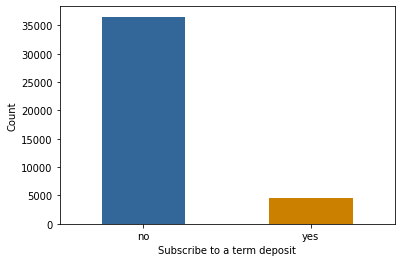

In [ ]:
grouped_df = train_data.groupby(train_data.columns[-1])
grouped_df.size().plot(kind='bar',color=[(0.2,0.4,0.6),(0.8,0.5,0)])

plt.xlabel('Subscribe to a term deposit')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.xticks(range(len(grouped_df.groups)), ['no', 'yes'])
plt.show()

In [ ]:
train_data.head()

In [ ]:
train_data.info()

In [ ]:
category_col = [col for col in train_data.columns.tolist() if train_data[col].dtype == object]
print(category_col)

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
for col in category_col:
    lc = LabelEncoder()
    train_data[col] = lc.fit_transform(train_data[col])

In [ ]:
train_data.info()

In [ ]:
X = train_data.drop("y", axis=1)
y = train_data['y']

## Scaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
x = MinMaxScaler().fit_transform(X)
x = pd.DataFrame(data=x, columns=X.columns.tolist())
x.head()

In [ ]:
# Save the processed data to csv file
x.to_csv("/content/data/processed_data.csv", index=False)

In [ ]:
y.to_csv("/content/data/y.csv", index=False)

# load processed data

In [ ]:
def load_data():
    training_set = None
    with open("/content/data/processed_data.csv", mode="r") as f:
        training_set = pd.read_csv(f)
    return training_set


def create_complete_data():
    training_set = load_data()
    size = training_set.shape
    train_dataset = tf.data.Dataset.from_tensor_slices(tf.constant(training_set.values, dtype = tf.float32, shape=size))
    input = train_dataset
    train_dataset = train_dataset.shuffle(TRAIN_BUF)
    train_dataset = train_dataset.batch(BATCH_SIZE)
    return train_dataset

# Model Definition

In [ ]:
class TVAE(tf.keras.Model):
    def __init__(self, latent_dim, input_dim):
        super(TVAE, self).__init__()
        self.latent_dim = latent_dim
        self.inference_net = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(input_dim,)),
            tf.keras.layers.Dense(units=input_dim, activation=tf.nn.tanh),
            tf.keras.layers.Dense(units=latent_dim, activation=tf.nn.relu),
            tf.keras.layers.Dense(units=latent_dim + latent_dim),
        ]
    )

        self.generative_net = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=latent_dim, activation=tf.nn.relu),
            tf.keras.layers.Dense(units=input_dim, activation=tf.nn.tanh),
            tf.keras.layers.Dense(units=input_dim),
            
        ]
    )

    def sample(self, eps=None):
        if eps is None:
            eps = tf.random_normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        model_output = self.inference_net(x)
        mean, logvar = tf.split(model_output, num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random_normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits


# Computing Loss

In [ ]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

def mean_squared_error(logit, ground_truth):
    error = (ground_truth - logit)
    MSE = tf.reduce_mean(tf.square(error), axis=1)
    return MSE

def compute_loss(model, x):
    mean, logvar = model.encode(x)
   
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    x = tf.reshape(x, x_logit.shape)

    MSE = mean_squared_error(logit=x_logit, ground_truth=x)
    logpx_z = -tf.reduce_sum(MSE, axis=0)

    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

def compute_gradients(model, x):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    return tape.gradient(loss, model.trainable_variables), loss

def apply_gradients(optimizer, gradients, variables, global_step=None):
    optimizer.apply_gradients(zip(gradients, variables))

# Model Training

In [ ]:
def train(data, feature_num, epochs):
    """
    Args:
        data: (DataSet) train data set
        feature_num: (int) number of feature
        removed_feature: (str) feature not used. 
        epochs: (int)
    """
    epochs = epochs   
    latent_dim = LATENT_DIM
    num_examples_to_generate = 16
    random_vector_for_generation = tf.random_normal(
        shape=[num_examples_to_generate, latent_dim]
    )
    model = TVAE(latent_dim, feature_num)

    optimizer = tf.train.AdamOptimizer(0.01)

    for epoch in range(1, epochs + 1):
        start_time = time.time()
        for train_x in data:
            gradients, loss = compute_gradients(model, train_x)
            apply_gradients(optimizer, gradients, model.trainable_variables)
        end_time = time.time()

        if epoch % 1 == 0:
            for train_sample_x in data.make_one_shot_iterator():
                train_loss(compute_loss(model, train_sample_x))
            train_elbo = train_loss.result()
            print(f'Epoch: {epoch}, duration: {end_time - start_time:.4f}s, train loss: {train_elbo}')
    
    x = pd.read_csv("/content/data/processed_data.csv")
    x = tf.convert_to_tensor(x.values)

    return model

In [ ]:
data = create_complete_data()
model = train(data, feature_num=19, epochs=300)

# Interpretations

### Steps 1-6 are for feature importance
#### Step 1

In [ ]:
mus = []
logvars = []
mu_grads = []
logvars_grads = []

for train_x in data:
    with tf.GradientTape(persistent=True) as g:
        g.watch(train_x)
        mean, logvar = model.encode(train_x)
        mus.append(mean)
        logvars.append(logvar)

        mu_i_grads = []
        logvars_i_grads = []
        for i in range(mean.shape[1]):
            mu_i_grads.append(g.gradient(mean[:, i], train_x))
            logvars_i_grads.append(g.gradient(logvar[:, i], train_x))
        
        mu_grads.append(mu_i_grads)
        logvars_grads.append(logvars_i_grads)

#### Step 2 

In [ ]:
sj_mu_xn_list = []
sj_sigma_xn_list = []

for i in range(len(mu_grads)):
   
    abs_sij_mu_xn = tf.abs(mu_grads[i][0])
    abs_sij_sigma_xn = tf.abs(logvars_grads[i][0])
    
    for j in range(1, len(mu_grads[i])):
        abs_sij_mu_xn += tf.abs(mu_grads[i][j])
        abs_sij_sigma_xn += tf.abs(logvars_grads[i][j])
    
    sj_mu_xn_list.append(abs_sij_mu_xn)
    sj_sigma_xn_list.append(abs_sij_sigma_xn)

sj_mu_xn = tf.concat(sj_mu_xn_list, axis=0)
sj_sigma_xn = tf.concat(sj_sigma_xn_list, axis=0)

print(f"shape of mu_grad_x: {sj_mu_xn.shape}")
print(f"shape of logvar_grad_x: {sj_sigma_xn.shape}")

In [ ]:
sj_xn = sj_mu_xn + sj_sigma_xn
print(sj_xn.shape)

In [ ]:
def plot_grad_normalize_in(idx):
    """
    Args:
        idx (int): index of data point
    """
    # normalization
    sj_xn_normalize = sj_xn / tf.reduce_sum(sj_xn, axis=1, keepdims=True)
    grad_in_idx = sj_xn_normalize[idx, :]
    fig = plt.figure(figsize=(10, 8))
    plt.bar(list(range(1, len(grad_in_idx)+1)), grad_in_idx)
    plt.xticks(list(range(1, len(grad_in_idx)+1)))
    plt.show()

def plot_grad_in(idx):
    """
    Args:
        idx (int): index of data point
    """
    grad_in_idx = sj_xn[idx, :]
    fig = plt.figure(figsize=(10, 8))
    plt.bar(list(range(1, len(grad_in_idx)+1)), grad_in_idx)
    plt.xticks(list(range(1, len(grad_in_idx)+1)))
    plt.show()

In [ ]:
#relative local feature importance
plot_grad_normalize_in(1)

In [ ]:
#local feature importance
plot_grad_in(1)

#### Step 3

In [ ]:
sij_mu_xn_square = []
sij_sigma_xn_square = []

for j in range(len(mu_grads[0])):
    
    # the element in the following list is grad of a batch data
    sij_mu_j_xn_square = []
    sij_sigma_j_xn_square = []

    for i in range(0, len(mu_grads)):
        sij_mu_j_xn_square.append(mu_grads[i][j] ** 2)
        sij_sigma_j_xn_square.append(logvars_grads[i][j] ** 2)
    
    sij_mu_xn_square.append(sij_mu_j_xn_square)
    sij_sigma_xn_square.append(sij_sigma_j_xn_square)

In [ ]:
sij_mu_sq = []
sij_sigma_sq = []
for j in range(len(sij_mu_xn_square)):
    tmp_mu = tf.concat(sij_mu_xn_square[j], axis=0)
    tmp_logvar = tf.concat(sij_sigma_xn_square[j], axis=0)

    sij_mu_sq.append(tf.math.sqrt(tf.reduce_mean(tmp_mu, axis=0, keep_dims=True)))
    sij_sigma_sq.append(tf.math.sqrt(tf.reduce_mean(tmp_logvar, axis=0, keep_dims=True)))

#### Step 4

In [ ]:
sj_mu_sq = tf.reduce_sum(tf.concat(sij_mu_sq, axis=0), axis=0, keepdims=True)
sj_sigma_sq = tf.reduce_sum(tf.concat(sij_sigma_sq, axis=0), axis=0, keepdims=True)

#### Step 5

In [ ]:
sj_sq = sj_mu_sq + sj_sigma_sq

In [ ]:
# global feature importance
fig = plt.figure(figsize=(10, 8))
plt.bar(list(range(19)), sj_sq.numpy().reshape(-1))
plt.xticks(list(range(19)), [str(i) for i in range(1, 20)])
plt.show()

#### Step 6

In [ ]:
# relative global feature importance
a = sj_sq.numpy().reshape(-1)
f = (a / a.sum()) * 100

fig = plt.figure(figsize=(10, 8))
plt.bar(list(range(19)), f)
plt.xticks(list(range(19)), [str(i) for i in range(1, 20)])
plt.show()

#### Step 7 Feature interaction

In [ ]:
train_x = []
for it in data:
    train_x.append(it)
train_x = tf.concat(train_x, axis=0)
print(f"shape of train_x: {train_x.shape}")

##### 7.1

In [ ]:
with tf.GradientTape(persistent=True) as g:
    with tf.GradientTape(persistent=True) as g2:
        g.watch(train_x)
        g2.watch(train_x)
        mean, logvar = model.encode(train_x)

        mjo_xn = []
        it = 0    # just a temp variable
        for i in range(mean.shape[1]):
        
            # first order grad
            dmu_i_divide_dxon = g.gradient(mean[:, i], train_x)
            dsigma_i_divide_dxon = g.gradient(logvar[:, i], train_x)
        
            # second order grad
            it += tf.abs(g2.batch_jacobian(dmu_i_divide_dxon, train_x))
            it += tf.abs(g2.batch_jacobian(dsigma_i_divide_dxon, train_x))
            mjo_xn.append(it)

In [ ]:
m_jj_xn = 0

for m in mjo_xn:
    m_jj_xn += m

print(f"shape of m_jj_xn {m_jj_xn.shape}")

In [ ]:
m_jj_reduce_mean = tf.reduce_mean(m_jj_xn, axis=0)

mask = 1 - tf.eye(m_jj_reduce_mean.shape[0].value)

m_jo = tf.reshape(m_jj_reduce_mean[tf.cast(mask, bool)], (1, -1))
print(f"shape of m_jo is: {m_jo.shape}")

##### 7.2

In [ ]:
m_j_xn = tf.reduce_sum(m_jj_xn * tf.expand_dims((1 - tf.eye(m_jj_xn.shape[1].value)), axis=0), axis=2)
print(f"shape of m_j_xn: {m_j_xn.shape}")

In [ ]:
def plot_mjxn_in(idx):
    """
    Args:
        idx (int): index of data point
    """
    grad_in_idx = m_j_xn.numpy()[idx, :]
    fig = plt.figure(figsize=(10, 8))
    plt.bar(list(range(1, len(grad_in_idx)+1)), grad_in_idx)
    plt.xticks(list(range(1, len(grad_in_idx)+1)))
    plt.show()

plot_mjxn_in(1)

In [ ]:
m_j = tf.reduce_mean(m_j_xn, axis=0)
print(f"shape of m_j: {m_j.shape}")

In [ ]:
fig = plt.figure(figsize=(10, 8))
plt.bar(list(range(len(m_j))), m_j)
plt.xticks(list(range(19)), [str(i+1) for i in range(19)])
plt.show()